In [14]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import requests
import asinfo

In [15]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [17]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [18]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [19]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , web_connect_time as w_time
                  , audio_connect_time as a_time
                  , video_connect_time as v_time
                  , startup_delay
                  , prebuffering_duration as pd
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           and successes = 1
           and failures = 0;
        '''

In [20]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [21]:
df.count()

probe            4422465
dtime            4422465
video_address    4422465
w_time           4346299
a_time           4422465
v_time           4422465
startup_delay    4346299
pd               4422465
dtype: int64

In [22]:
df.head()

,probe,dtime,video_address,w_time,a_time,v_time,startup_delay,pd
0,samsbox81,2016-09-05 16:29:41,193.212.4.15,6916.0,8731,7658,1179709.0,528170
1,samsbox81,2016-09-05 16:30:23,2001:4600:9:307::f,17844.0,11176,10076,1046380.0,542534
2,samsbox81,2016-09-05 17:26:17,193.212.4.15,7122.0,8904,7760,1050626.0,538893
3,samsbox81,2016-09-05 17:26:59,2001:4600:9:307::f,17781.0,11010,9826,1033682.0,544550
4,samsbox81,2016-09-05 18:25:53,193.212.4.15,8110.0,9015,7859,1087679.0,558563


In [23]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [24]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [25]:
df = df.sort_values('dtime')

In [26]:
df.head()

,probe,dtime,video_address,w_time,a_time,v_time,startup_delay,pd
3036654,samsbox24,2014-08-20 01:00:00,173.194.137.147,NaN,17455,16764,NaN,279739
3036655,samsbox24,2014-08-20 04:00:00,173.194.137.147,NaN,17501,19992,NaN,301344
3036656,samsbox24,2014-08-20 06:00:00,173.194.137.147,NaN,17105,17226,NaN,282252
3036657,samsbox24,2014-08-20 08:00:00,173.194.137.147,NaN,17100,20053,NaN,296452
3036658,samsbox24,2014-08-20 09:00:00,173.194.137.147,NaN,19009,19057,NaN,289677


In [27]:
df.tail()

,probe,dtime,video_address,w_time,a_time,v_time,startup_delay,pd
1979966,samsbox60,2017-06-27 23:00:00,173.194.61.40,22594.0,19639,18952,1398930.0,679307
2942273,samsbox93,2017-06-27 23:00:00,2607:f8b0:400a:14::8,28582.0,19854,18706,1289122.0,604367
2409424,samsbox98,2017-06-27 23:00:00,173.194.160.152,23838.0,19514,18347,1637748.0,936900
3481891,samsbox75,2017-06-27 23:00:00,74.125.13.42,1652.0,1640,1116,1088307.0,592534
4422464,samsbox91,2017-06-27 23:00:00,62.231.78.13,19917.0,6344,5199,1169666.0,532110


In [28]:
num_probes = len(set(df['probe']))

In [29]:
df.count()

probe            4422465
dtime            4422465
video_address    4422465
w_time           4346299
a_time           4422465
v_time           4422465
startup_delay    4346299
pd               4422465
dtype: int64

In [30]:
df = df.dropna()

In [31]:
df.count()

probe            4346299
dtime            4346299
video_address    4346299
w_time           4346299
a_time           4346299
v_time           4346299
startup_delay    4346299
pd               4346299
dtype: int64

In [32]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [33]:
dfv4, dfv6 = filter_by_ip(df, column = 'video_address')

In [34]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [35]:
dfv4.head()

,dtime,video_address,w_time,a_time,v_time,startup_delay,pd,name
3037786,2014-12-10 12:00:00,74.125.105.178,16265.0,17384,17224,762687.0,341348,#24
12246,2014-12-10 12:00:00,64.15.112.79,17429.0,16168,16517,812486.0,399912,#02
2117093,2014-12-10 12:00:00,149.3.177.111,35657.0,38650,37155,1601325.0,860880,#06
4302454,2014-12-10 13:00:00,74.125.15.82,40688.0,36044,33055,1207749.0,522773,#11
4302453,2014-12-10 13:00:00,83.255.235.15,19168.0,12199,12613,855760.0,408308,#11


In [36]:
dfv6.head()

,dtime,video_address,w_time,a_time,v_time,startup_delay,pd,name
2265090,2014-12-10 12:00:00,2a00:1450:4005:6::12,29924.0,21590,21763,1311590.0,578754,#04
3987059,2014-12-10 12:00:00,2a00:1450:400a:6::12,5203.0,53338,52224,903131.0,538043,#16
1779714,2014-12-10 12:00:00,2a00:1450:4009:29::12,57187.0,41047,41498,1287188.0,421167,#07
1779713,2014-12-10 12:00:00,2a00:1450:4003:15::12,25108.0,61707,61746,999274.0,466046,#07
3844417,2014-12-10 12:00:00,2001:1a80:100:1c::c,15060.0,13701,13842,875990.0,414562,#03


In [37]:
df = pd.merge(dfv4, dfv6, on=["name", "dtime"])

In [38]:
df.count()

dtime              6549945
video_address_x    6549945
w_time_x           6549945
a_time_x           6549945
v_time_x           6549945
startup_delay_x    6549945
pd_x               6549945
name               6549945
video_address_y    6549945
w_time_y           6549945
a_time_y           6549945
v_time_y           6549945
startup_delay_y    6549945
pd_y               6549945
dtype: int64

In [39]:
df.rename(columns={  'video_address_x'      : 'v_ep_v4'
                   , 'w_time_x'             : 'w_v4'
                   , 'a_time_x'             : 'a_v4'
                   , 'v_time_x'             : 'v_v4'                   
                   , 'startup_delay_x'      : 's_v4'             
                   , 'pd_x'                 : 'p_v4'                   
                   , 'video_address_y'      : 'v_ep_v6'
                   , 'w_time_y'             : 'w_v6'
                   , 'a_time_y'             : 'a_v6'
                   , 'v_time_y'             : 'v_v6'                   
                   , 'startup_delay_y'      : 's_v6'             
                   , 'pd_y'                 : 'p_v6'                                      
                  } ,  inplace=True)

In [40]:
df.head()

,dtime,v_ep_v4,w_v4,a_v4,v_v4,s_v4,p_v4,name,v_ep_v6,w_v6,a_v6,v_v6,s_v6,p_v6
0,2014-12-10 12:00:00,64.15.112.79,17429.0,16168,16517,812486.0,399912,#02,2a00:1450:4005:6::12,16136.0,13244,13598,823774.0,390896
1,2014-12-10 12:00:00,149.3.177.111,35657.0,38650,37155,1601325.0,860880,#06,2a00:1450:4002:9::12,36757.0,35595,34203,1712994.0,742766
2,2014-12-10 13:00:00,149.3.177.111,34160.0,39748,37298,1402994.0,709893,#06,2a00:1450:4002:9::12,40201.0,36146,35134,1642471.0,798319
3,2014-12-10 13:00:00,202.224.62.79,22511.0,21983,22085,1227717.0,582028,#12,2404:6800:400a:8::12,47443.0,38578,38122,1563074.0,657032
4,2014-12-10 13:00:00,202.224.62.79,22511.0,21983,22085,1227717.0,582028,#12,2a00:1450:4009:29::12,46896.0,265018,267132,3307632.0,2440394


In [41]:
df.count()

dtime      6549945
v_ep_v4    6549945
w_v4       6549945
a_v4       6549945
v_v4       6549945
s_v4       6549945
p_v4       6549945
name       6549945
v_ep_v6    6549945
w_v6       6549945
a_v6       6549945
v_v6       6549945
s_v6       6549945
p_v6       6549945
dtype: int64

In [42]:
df['v4v6_p']  = df.p_v4.map(str) + ',' + df.p_v6.map(str)
df['v4v6_s']  = df.s_v4.map(str) + ',' + df.s_v6.map(str)
df['v4v6_w']  = df.w_v4.map(str) + ',' + df.w_v6.map(str)
df['v4v6_a']  = df.a_v4.map(str) + ',' + df.a_v6.map(str)
df['v4v6_v']  = df.v_v4.map(str) + ',' + df.v_v6.map(str)

In [43]:
df.head()

,dtime,v_ep_v4,w_v4,a_v4,v_v4,s_v4,p_v4,name,v_ep_v6,w_v6,a_v6,v_v6,s_v6,p_v6,v4v6_p,v4v6_s,v4v6_w,v4v6_a,v4v6_v
0,2014-12-10 12:00:00,64.15.112.79,17429.0,16168,16517,812486.0,399912,#02,2a00:1450:4005:6::12,16136.0,13244,13598,823774.0,390896,"399912,390896","812486.0,823774.0","17429.0,16136.0","16168,13244","16517,13598"
1,2014-12-10 12:00:00,149.3.177.111,35657.0,38650,37155,1601325.0,860880,#06,2a00:1450:4002:9::12,36757.0,35595,34203,1712994.0,742766,"860880,742766","1601325.0,1712994.0","35657.0,36757.0","38650,35595","37155,34203"
2,2014-12-10 13:00:00,149.3.177.111,34160.0,39748,37298,1402994.0,709893,#06,2a00:1450:4002:9::12,40201.0,36146,35134,1642471.0,798319,"709893,798319","1402994.0,1642471.0","34160.0,40201.0","39748,36146","37298,35134"
3,2014-12-10 13:00:00,202.224.62.79,22511.0,21983,22085,1227717.0,582028,#12,2404:6800:400a:8::12,47443.0,38578,38122,1563074.0,657032,"582028,657032","1227717.0,1563074.0","22511.0,47443.0","21983,38578","22085,38122"
4,2014-12-10 13:00:00,202.224.62.79,22511.0,21983,22085,1227717.0,582028,#12,2a00:1450:4009:29::12,46896.0,265018,267132,3307632.0,2440394,"582028,2440394","1227717.0,3307632.0","22511.0,46896.0","21983,265018","22085,267132"


### Calculate Absolute Difference

In [44]:
def get_difference(v4v6_delay, divider):
    
    v4, v6 = v4v6_delay.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_delay)
    
    difference = (v4 - v6)
    difference = difference / divider              
    return float('%0.2f'%difference)

def get_s_delay_difference(v4v6_s_delay):
    return get_difference(v4v6_s_delay, 1000000) # to seconds

def get_t_delay_difference(v4v6_t_delay):
    return get_difference(v4v6_t_delay, 1000) # to milliseconds

df['p_a'] = df['v4v6_p'].apply(get_s_delay_difference)
df['s_a'] = df['v4v6_s'].apply(get_s_delay_difference)

df['w_a'] = df['v4v6_w'].apply(get_t_delay_difference)
df['a_a'] = df['v4v6_a'].apply(get_t_delay_difference)
df['v_a'] = df['v4v6_v'].apply(get_t_delay_difference)

### Calculate Relative Difference

In [45]:
def get_slowness(v4v6_s_delay):
    
    v4, v6 = v4v6_s_delay.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_s_delay)
    
    try: slowness = (v4 - v6) / v4
    except Exception as e: return 0
    return float('%0.2f'%slowness)

df['p_r'] = df['v4v6_p'].apply(get_slowness)
df['s_r'] = df['v4v6_s'].apply(get_slowness)
df['w_r'] = df['v4v6_w'].apply(get_slowness)
df['a_r'] = df['v4v6_a'].apply(get_slowness)
df['v_r'] = df['v4v6_v'].apply(get_slowness)

In [46]:
del df['v4v6_p']
del df['v4v6_s']
del df['v4v6_w']
del df['v4v6_a']
del df['v4v6_v']

In [47]:
df.count()

dtime      6549945
v_ep_v4    6549945
w_v4       6549945
a_v4       6549945
v_v4       6549945
s_v4       6549945
p_v4       6549945
name       6549945
v_ep_v6    6549945
w_v6       6549945
a_v6       6549945
v_v6       6549945
s_v6       6549945
p_v6       6549945
p_a        6549945
s_a        6549945
w_a        6549945
a_a        6549945
v_a        6549945
p_r        6549945
s_r        6549945
w_r        6549945
a_r        6549945
v_r        6549945
dtype: int64

In [48]:
df.head()

,dtime,v_ep_v4,w_v4,a_v4,v_v4,s_v4,p_v4,name,v_ep_v6,w_v6,...,p_a,s_a,w_a,a_a,v_a,p_r,s_r,w_r,a_r,v_r
0,2014-12-10 12:00:00,64.15.112.79,17429.0,16168,16517,812486.0,399912,#02,2a00:1450:4005:6::12,16136.0,...,0.01,-0.01,1.29,2.92,2.92,0.02,-0.01,0.07,0.18,0.18
1,2014-12-10 12:00:00,149.3.177.111,35657.0,38650,37155,1601325.0,860880,#06,2a00:1450:4002:9::12,36757.0,...,0.12,-0.11,-1.10,3.06,2.95,0.14,-0.07,-0.03,0.08,0.08
2,2014-12-10 13:00:00,149.3.177.111,34160.0,39748,37298,1402994.0,709893,#06,2a00:1450:4002:9::12,40201.0,...,-0.09,-0.24,-6.04,3.60,2.16,-0.12,-0.17,-0.18,0.09,0.06
3,2014-12-10 13:00:00,202.224.62.79,22511.0,21983,22085,1227717.0,582028,#12,2404:6800:400a:8::12,47443.0,...,-0.08,-0.34,-24.93,-16.59,-16.04,-0.13,-0.27,-1.11,-0.75,-0.73
4,2014-12-10 13:00:00,202.224.62.79,22511.0,21983,22085,1227717.0,582028,#12,2a00:1450:4009:29::12,46896.0,...,-1.86,-2.08,-24.39,-243.03,-245.05,-3.19,-1.69,-1.08,-11.06,-11.10


In [49]:
import Cdf
import Pmf

sample = df['p_a'].values
pd_c     = Cdf.MakeCdfFromList(sample)
pd_cc    = [1 - p for x, p in pd_c.Items()]

sample = df['s_a'].values
s_c      = Cdf.MakeCdfFromList(sample)
s_cc     = [1 - p for x, p in s_c.Items()]

sample = df['w_a'].values
w_c      = Cdf.MakeCdfFromList(sample)
w_cc     = [1 - p for x, p in w_c.Items()]

sample = df['a_a'].values
a_c      = Cdf.MakeCdfFromList(sample)
a_cc     = [1 - p for x, p in a_c.Items()]

sample = df['v_a'].values
v_c      = Cdf.MakeCdfFromList(sample)
v_cc     = [1 - p for x, p in v_c.Items()]

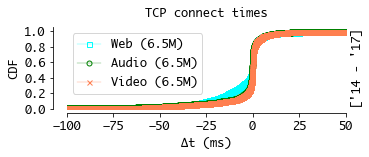

In [56]:
fig = plt.figure(figsize = (5,1.5))
plt.rcParams['font.size'] = 12
ax = plt.gca()
yticks = np.arange(0,1.1,0.2)

plt.plot(w_c.xs, w_c.ps, marker='s', linewidth=0.3, markersize=5, fillstyle='none', color = 'Cyan')
plt.plot(a_c.xs, a_c.ps, marker='o', linewidth=0.3, markersize=5, fillstyle='none', color = 'Green')
plt.plot(v_c.xs, v_c.ps, marker='x', linewidth=0.3, markersize=5, fillstyle='none', color = 'Coral')

ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_xlim([-100,50])
ax.set_ylim([0,1.05])
ax.set_xscale('linear')
ax.set_xlabel('∆t (ms)', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)

plt.legend(["Web (6.5M)", "Audio (6.5M)", "Video (6.5M)"], fontsize=12, loc='upper left')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
ax3.set_ylabel('[\'14 - \'17]')
plt.setp(ax3.get_yticklabels(), visible=False)

plt.title('TCP connect times', fontsize=12, y=1.05)
plt.savefig('yt-syn-time-absolute-difference.pdf', format='pdf', bbox_inches='tight')

### CDF of absolute difference of TCP connect times between IPv4 and IPv6 over the entire duration. 40% of the audio and video streams are faster over IPv6 with 8% of them being atleast 10 ms faster and 2% being atleast 100 ms faster. On the contrary, 35% of the audio and video streams are atleast 1 ms slower over IPv6 with 15% of them being atleast 10 ms slower. Worse, 4% of the samples are atleast 50 ms slower and 3% being atleast 100 ms slower over IPv6. The web connect times favour IPv6 even less where only 27% of the samples are faster over IPv6 with 4% being atleast 10ms faster and 1% being atleast 100 ms faster. Half of the web connections are atleast 1 ms slower over IPv6 with 25% of them being atleast 10 ms slower.  Worse, 7% of the samples are atleast 50 ms slower and 3% being atleast 100 ms slower over IPv6

In [51]:
with open('syn-times-video.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(v_c.xs, v_c.ps): f.write('%.2f; %.2f\n'%(x,y))
        
with open('syn-times-audio.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(a_c.xs, a_c.ps): f.write('%.2f; %.2f\n'%(x,y))        
        
with open('syn-times-web.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(w_c.xs, w_c.ps): f.write('%.2f; %.2f\n'%(x,y))                

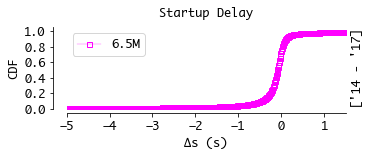

In [57]:
fig = plt.figure(figsize = (5,1.5))
plt.rcParams['font.size'] = 12
ax = plt.gca()
yticks = np.arange(0,1.1,0.2)

plt.plot(s_c.xs, s_c.ps, marker='s', linewidth=0.3, markersize=5, fillstyle='none', color = 'Magenta')

ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_xlim([-5,1.5])
ax.set_ylim([0,1.05])
ax.set_xscale('linear')
ax.set_xlabel('∆s (s)', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)

plt.legend(["6.5M"], fontsize=12, loc='upper left')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
ax3.set_ylabel('[\'14 - \'17]')
plt.setp(ax3.get_yticklabels(), visible=False)

plt.title('Startup Delay', fontsize=12, y=1.05)
plt.savefig('yt-startup-delay-absolute-difference.pdf', format='pdf', bbox_inches='tight')

### CDF of absolute difference of startup delay between IPv4 and IPv6 over the entire duration. 20% of the samples are faster over IPv6 with 10% of them being atleast 100 ms faster and 2% being atleast 1s faster. On the contrary, half of the samples are atleast 100 ms slower over IPv6 with 25% of them being atleast 300 ms slower. Worse 8% of the samples are atleast 1s slower and 4% being atleast 2s slower over IPv6.

In [53]:
with open('startup-delay.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(s_c.xs, s_c.ps): f.write('%.2f; %.2f\n'%(x,y))